<a href="https://colab.research.google.com/github/jinsujeon/mge51101-20196032/blob/master/midterm_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Skeleton code for CIFAR datasets

- use this code for the implementation of CIFAR dataloaders

In [7]:
!nvidia-smi
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
print(torch.__version__)
import torch.nn.functional as F

Mon Apr 27 06:31:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    34W / 250W |   1619MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Model

- write your LeNet and AlexNet code in the following `MyCNN` class

In [0]:

class Lenet(nn.Module):
    def __init__(self):
        super(Lenet, self).__init__()
        
        self.conv1 = nn.Conv2d(3,6,5)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)

    
    def forward(self, inputs):

        inputs = F.max_pool2d(F.relu(self.conv1(inputs)),2)
        inputs = F.max_pool2d(F.relu(self.conv2(inputs)),2)
        inputs = inputs.view(inputs.size()[0],-1)
        inputs = F.relu(self.fc1(inputs))
        inputs = F.relu(self.fc2(inputs))
        outputs = self.fc3(inputs)

        return outputs

model = Lenet().cuda()

# Loss function & Optimizers
"""
you can change the loss and optimizer
"""
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


# Hyperparameters
"""
you can change the value
"""
num_epochs = 60
batch_size = 128

## Training & Evaluation

- Don't change the below codes

Files already downloaded and verified
Files already downloaded and verified

train accuracy: 33.59 %, test accuracy: 43.87 %
epoch:1, train_loss: 1.8150, test_loss: 1.5492

train accuracy: 60.60 %, test accuracy: 63.86 %
epoch:11, train_loss: 1.1093, test_loss: 1.0395

train accuracy: 64.96 %, test accuracy: 66.32 %
epoch:21, train_loss: 0.9928, test_loss: 0.9588

train accuracy: 66.70 %, test accuracy: 69.32 %
epoch:31, train_loss: 0.9399, test_loss: 0.8783

train accuracy: 68.30 %, test accuracy: 69.35 %
epoch:41, train_loss: 0.9041, test_loss: 0.8722

train accuracy: 68.94 %, test accuracy: 70.81 %
epoch:51, train_loss: 0.8815, test_loss: 0.8405


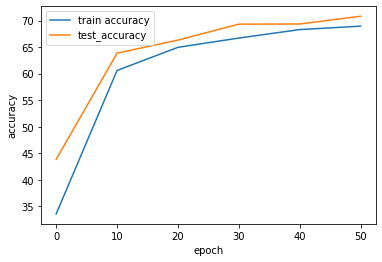

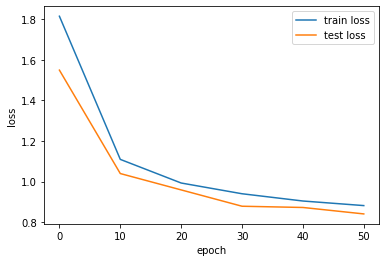

In [9]:
import sys
sys.path.insert(0, "..")
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

# CIFAR preprocessing 
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# DataLoader for CIFAR-10
cifar_train = torchvision.datasets.CIFAR10(root="./", 
                                         train=True, 
                                         download=True,
                                         transform=transform_train
                                         )
cifar_test = torchvision.datasets.CIFAR10(root="./", 
                                        train=False, 
                                        download=True,
                                        transform=transform_test)


train_loader = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=4)

 
accuracy_graph = {'train':[], 'test':[], 'epoch': []}
loss_graph = {'train':[], 'test':[], 'epoch': []}

class accumulator():
    def __init__(self):
        self.cnt = 0
        self.obs = 0
        self.loss = 0

    def add(self, predict, output):

        assert len(predict) == len(output)

        self.cnt += self.count(predict, output).cpu().numpy()
        self.obs += len(predict)
    
    def count(self, predict, output):
        correct = torch.sum(torch.argmax(predict, dim=1) == output)
        
        return correct
        
    def loss_update(self, loss, batch_size):
        self.loss += loss * batch_size

    def running_stat(self):
        if self.obs != 0:
            run_acc = 100 * self.cnt / self.obs
            run_loss = self.loss / self.obs
        else: 
            run_acc = 0
            rum_loss = 0

        return run_acc, run_loss

    def reset(self):
        self.__init__()


for epoch in range(num_epochs):

    train_accuracy = accumulator()
    test_accuracy = accumulator()

    # Training
    for train_x, train_y in train_loader: 

        train_x, train_y = train_x.cuda(), train_y.cuda()
        train_predict = model(train_x)
        loss = criterion(train_predict, train_y)

        # Backpropagation        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_accuracy.add(train_predict, train_y)
        train_accuracy.loss_update(loss, batch_size)

    # Evaluation
    if epoch % 10 ==0:
             
        for test_x, test_y in test_loader:

            with torch.autograd.no_grad():
                test_x, test_y = test_x.cuda(), test_y.cuda()
                test_predict = model(test_x)
                test_accuracy.add(test_predict, test_y)

            loss_test = criterion(test_predict, test_y)
            test_accuracy.loss_update(loss_test, batch_size)

        train_acc, train_loss = train_accuracy.running_stat()
        test_acc, test_loss = test_accuracy.running_stat()
        accuracy_graph['train'].append(train_acc)
        accuracy_graph['test'].append(test_acc) 
        accuracy_graph['epoch'].append(epoch)
        loss_graph['train'].append(train_loss)
        loss_graph['test'].append(test_loss)
        loss_graph['epoch'].append(epoch)
        
        print("\ntrain accuracy: {:.2f} %, test accuracy: {:.2f} %".format(train_acc, test_acc))
        print("epoch:{}, train_loss: {:.4f}, test_loss: {:.4f}".format(epoch+1, train_loss, test_loss)) 

        train_accuracy.reset(), test_accuracy.reset()


plt.plot(accuracy_graph['epoch'], accuracy_graph['train'], label = "train accuracy");
plt.plot(accuracy_graph['epoch'], accuracy_graph['test'], label = "test_accuracy");
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

plot_loss_train = plt.plot(loss_graph['epoch'], loss_graph['train'], label="train loss");
plt.plot(loss_graph['epoch'], loss_graph['test'], label="test loss");
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [0]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,96,5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(96,256,5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(256,384,2,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,384,2,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256,2,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(64*8*8,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000,10),
        )
    
    def forward(self, inputs):
        inputs = self.features(inputs)
        inputs = torch.flatten(inputs,1)
        outputs = self.classifier(inputs)

        return outputs

model = AlexNet().cuda()

# Loss function & Optimizers
"""
you can change the loss and optimizer
"""
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


# Hyperparameters
"""
you can change the value
"""
num_epochs = 80
batch_size = 128

Files already downloaded and verified
Files already downloaded and verified

train accuracy: 32.15 %, test accuracy: 46.75 %
epoch:1, train_loss: 1.7807, test_loss: 1.4565

train accuracy: 71.36 %, test accuracy: 72.53 %
epoch:11, train_loss: 0.8324, test_loss: 0.8202

train accuracy: 77.13 %, test accuracy: 77.16 %
epoch:21, train_loss: 0.6738, test_loss: 0.6960

train accuracy: 79.53 %, test accuracy: 78.93 %
epoch:31, train_loss: 0.6046, test_loss: 0.6572

train accuracy: 81.47 %, test accuracy: 80.57 %
epoch:41, train_loss: 0.5518, test_loss: 0.5932

train accuracy: 82.61 %, test accuracy: 80.52 %
epoch:51, train_loss: 0.5147, test_loss: 0.6131

train accuracy: 83.93 %, test accuracy: 80.82 %
epoch:61, train_loss: 0.4864, test_loss: 0.6275

train accuracy: 84.52 %, test accuracy: 81.30 %
epoch:71, train_loss: 0.4590, test_loss: 0.6156


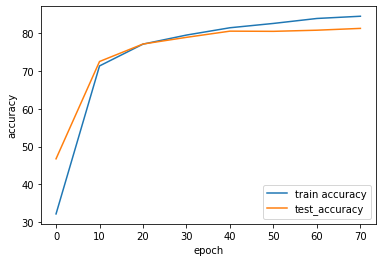

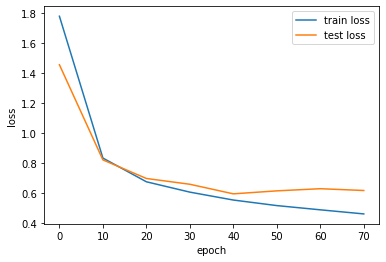

In [11]:
import sys
sys.path.insert(0, "..")
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

# CIFAR preprocessing 
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# DataLoader for CIFAR-10
cifar_train = torchvision.datasets.CIFAR10(root="./", 
                                         train=True, 
                                         download=True,
                                         transform=transform_train
                                         )
cifar_test = torchvision.datasets.CIFAR10(root="./", 
                                        train=False, 
                                        download=True,
                                        transform=transform_test)


train_loader = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=4)

 
accuracy_graph = {'train':[], 'test':[], 'epoch': []}
loss_graph = {'train':[], 'test':[], 'epoch': []}

class accumulator():
    def __init__(self):
        self.cnt = 0
        self.obs = 0
        self.loss = 0

    def add(self, predict, output):

        assert len(predict) == len(output)

        self.cnt += self.count(predict, output).cpu().numpy()
        self.obs += len(predict)
    
    def count(self, predict, output):
        correct = torch.sum(torch.argmax(predict, dim=1) == output)
        
        return correct
        
    def loss_update(self, loss, batch_size):
        self.loss += loss * batch_size

    def running_stat(self):
        if self.obs != 0:
            run_acc = 100 * self.cnt / self.obs
            run_loss = self.loss / self.obs
        else: 
            run_acc = 0
            rum_loss = 0

        return run_acc, run_loss

    def reset(self):
        self.__init__()


for epoch in range(num_epochs):

    train_accuracy = accumulator()
    test_accuracy = accumulator()

    # Training
    for train_x, train_y in train_loader: 

        train_x, train_y = train_x.cuda(), train_y.cuda()
        train_predict = model(train_x)
        loss = criterion(train_predict, train_y)

        # Backpropagation        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_accuracy.add(train_predict, train_y)
        train_accuracy.loss_update(loss, batch_size)

    # Evaluation
    if epoch % 10 ==0:
             
        for test_x, test_y in test_loader:

            with torch.autograd.no_grad():
                test_x, test_y = test_x.cuda(), test_y.cuda()
                test_predict = model(test_x)
                test_accuracy.add(test_predict, test_y)

            loss_test = criterion(test_predict, test_y)
            test_accuracy.loss_update(loss_test, batch_size)

        train_acc, train_loss = train_accuracy.running_stat()
        test_acc, test_loss = test_accuracy.running_stat()
        accuracy_graph['train'].append(train_acc)
        accuracy_graph['test'].append(test_acc) 
        accuracy_graph['epoch'].append(epoch)
        loss_graph['train'].append(train_loss)
        loss_graph['test'].append(test_loss)
        loss_graph['epoch'].append(epoch)
        
        print("\ntrain accuracy: {:.2f} %, test accuracy: {:.2f} %".format(train_acc, test_acc))
        print("epoch:{}, train_loss: {:.4f}, test_loss: {:.4f}".format(epoch+1, train_loss, test_loss)) 

        train_accuracy.reset(), test_accuracy.reset()


plt.plot(accuracy_graph['epoch'], accuracy_graph['train'], label = "train accuracy");
plt.plot(accuracy_graph['epoch'], accuracy_graph['test'], label = "test_accuracy");
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

plot_loss_train = plt.plot(loss_graph['epoch'], loss_graph['train'], label="train loss");
plt.plot(loss_graph['epoch'], loss_graph['test'], label="test loss");
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()